In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch
from depth_map_new import dense_map_new

# Class for the calibration matrices for KITTI data
class Calibration:
    def __init__(self, calib_filepath):
        calibs = self.read_calib_file(calib_filepath)

        self.P = calibs['P2']
        self.P = np.reshape(self.P, [3,4])

        self.L2C = calibs['Tr_velo_to_cam']
        self.L2C = np.reshape(self.L2C, [3,4])

        self.R0 = calibs['R0_rect']
        self.R0 = np.reshape(self.R0,[3,3])

    @staticmethod
    def read_calib_file(filepath):
        data = {}
        with open(filepath, 'r') as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line)==0: continue
                key, value = line.split(':', 1)
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data
    
    # From LiDAR coordinate system to Camera Coordinate system
    def lidar2cam(self, pts_3d_lidar):
        n = pts_3d_lidar.shape[0]
        pts_3d_hom = np.hstack((pts_3d_lidar, np.ones((n,1))))
        pts_3d_cam_ref = np.dot(pts_3d_hom, np.transpose(self.L2C))
        pts_3d_cam_rec = np.transpose(np.dot(self.R0, np.transpose(pts_3d_cam_ref)))
        return pts_3d_cam_rec
    
    # From Camera Coordinate system to Image frame
    def rect2Img(self, rect_pts, img_width, img_height):
        n = rect_pts.shape[0]
        points_hom = np.hstack((rect_pts, np.ones((n,1))))
        points_2d = np.dot(points_hom, np.transpose(self.P)) # nx3
        points_2d[:,0] /= points_2d[:,2]
        points_2d[:,1] /= points_2d[:,2]
        
        mask = (points_2d[:,0] >= 0) & (points_2d[:,0] <= img_width) & (points_2d[:,1] >= 0) & (points_2d[:,1] <= img_height)
        mask = mask & (rect_pts[:,2] > 2)
        return points_2d[mask,0:2], mask

In [2]:
root = ""
image_dir = os.path.join(root, "./")
velodyne_dir = os.path.join(root, "./")
calib_dir = os.path.join(root, "./")
# Data id
cur_id = 0
# Loading the image
img = cv2.imread(os.path.join(image_dir, "%06d.png" % cur_id))
# Loading the LiDAR data
lidar = np.fromfile(os.path.join(velodyne_dir, "%06d.bin" % cur_id), dtype=np.float32).reshape(-1, 4)
# Loading Calibration
calib = Calibration(os.path.join(calib_dir, "%06d.txt" % cur_id))
# From LiDAR coordinate system to Camera Coordinate system
lidar_rect = calib.lidar2cam(lidar[:,0:3])
# From Camera Coordinate system to Image frame
lidarOnImage, mask = calib.rect2Img(lidar_rect, img.shape[1], img.shape[0])
# Concatenate LiDAR position with the intesity (3), with (2) we would have the depth
lidarOnImage = np.concatenate((lidarOnImage, lidar_rect[mask,2].reshape(-1,1)), 1)

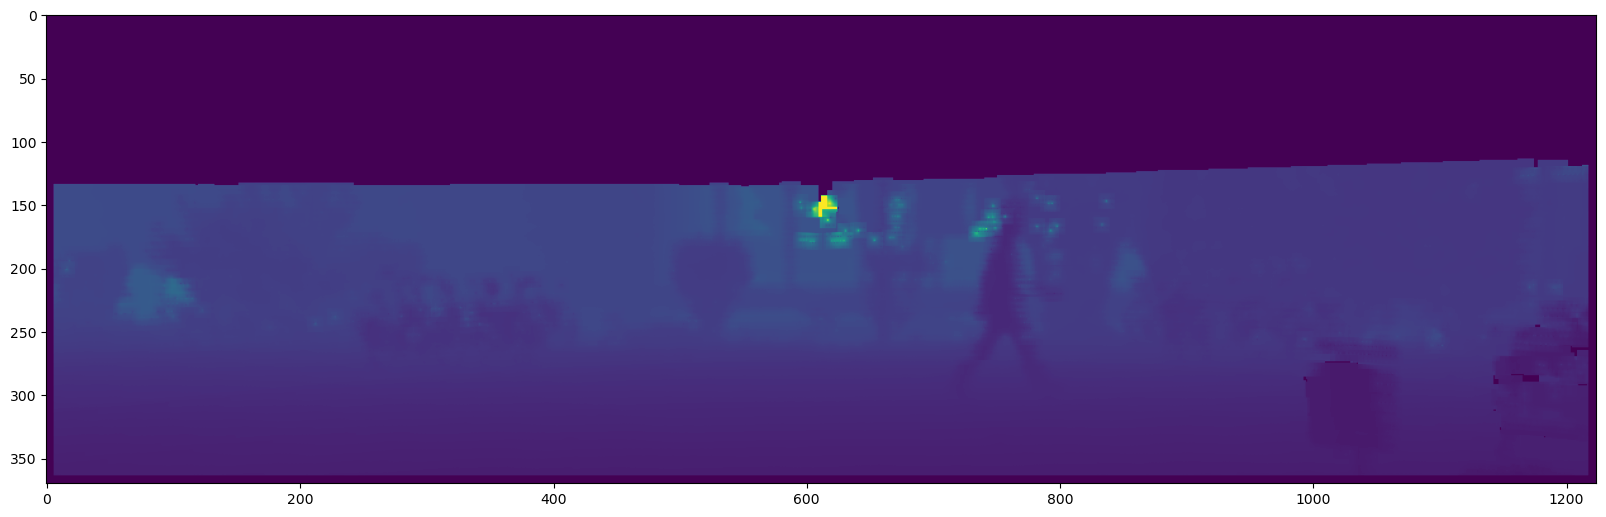

In [4]:
# out = dense_map(lidarOnImage.T, img.shape[1], img.shape[0], 1)
# plt.figure(figsize=(20,40))
# plt.imsave("depth_map_%06d.png" % cur_id, out)

#!!!!!!!!!!!!!!!!!! use 'lidarOnImage', not!!! 'lidarOnImage.T'
out = dense_map_new(lidarOnImage, img.shape[1], img.shape[0], 6)
plt.figure(figsize=(20,40))
# plt.imsave("depth_map_new_%06d.png" % cur_id, out)
plt.imshow(out)